In [2]:
import pandas as pd
import duckdb
import seaborn as sns
from matplotlib import pyplot as plt

# What is the average lifetime value (LTV) for Monthly users and how many times on average users successfully renew their subscription?
Assuming that renewal is defined as the second and so forth payments

In [3]:
accrual_basis_payments = pd.read_csv('../files/accrual_basis_payments.csv', encoding='utf-8', sep=';')
cash_flow_payments = pd.read_csv('../files/cash_flow_payments.csv', encoding='utf-8', sep=';')
users_subscriptions = pd.read_csv('../files/users_subscriptions.csv', encoding='utf-8', sep=';')

In [4]:
accrual_basis_payments.head()

,user_id,subscription_id,subscription_type,subscription_price,payment_date,payment_number,payment_value
0,f2ebae42-6e1e-46e2-83aa-79586bc2ee3e,43052bac-efe5-4cb1-80f5-b49e908379bc,Yearly,139.93,2022-12-02,1,11.660833
1,f2ebae42-6e1e-46e2-83aa-79586bc2ee3e,43052bac-efe5-4cb1-80f5-b49e908379bc,Yearly,139.93,2023-01-02,2,11.660833
2,f2ebae42-6e1e-46e2-83aa-79586bc2ee3e,43052bac-efe5-4cb1-80f5-b49e908379bc,Yearly,139.93,2023-02-02,3,11.660833
3,f2ebae42-6e1e-46e2-83aa-79586bc2ee3e,43052bac-efe5-4cb1-80f5-b49e908379bc,Yearly,139.93,2023-03-02,4,11.660833
4,f2ebae42-6e1e-46e2-83aa-79586bc2ee3e,43052bac-efe5-4cb1-80f5-b49e908379bc,Yearly,139.93,2023-04-02,5,11.660833


In [22]:
qry = """
    SELECT
        SUM(payments.payment_value) / COUNT(DISTINCT payments.user_id) AS avg_LTV
    FROM
        accrual_basis_payments AS payments
    WHERE
        payments.subscription_type = 'Monthly'
"""

avg_ltv = duckdb.query(qry).df().squeeze()



qry = """
    WITH cte_max_payment_number AS (
        SELECT 
            user_id
            , MAX(payment_number - 1) AS max_payment_number     -- we subtract 1 of payment_number to follow the rule about the concept of subscriptions renewal
        FROM
            accrual_basis_payments
        WHERE
            subscription_type = 'Monthly'
        GROUP BY
            user_id
    )

    SELECT 
        AVG(max_payment_number) AS avg_renewal_cnt
    FROM 
        cte_max_payment_number
"""

avg_renewal_cnt = duckdb.query(qry).df().squeeze()


print(f'The average LTV for Monthly users is €{round(avg_ltv, 1)}')
print(f'Montly users renewal their subscriptions {int(avg_renewal_cnt)} times on average')


print('-' * 50)
print('Avg LTV by the Basics Completed flag:')
qry = """
    SELECT
        subs.basics_completed
        , SUM(payments.payment_value) / COUNT(DISTINCT payments.user_id) AS avg_LTV
    FROM
        accrual_basis_payments AS payments
        INNER JOIN 
            users_subscriptions AS subs 
                ON payments.subscription_id = subs.subscription_id
    WHERE
        payments.subscription_type = 'Monthly'
    GROUP BY
        subs.basics_completed
"""

duckdb.query(qry).df().squeeze()

The average LTV for Monthly users is €310.4
Montly users renewal their subscriptions 12 times on average
--------------------------------------------------
Avg LTV by the Basics Completed flag:


,basics_completed,avg_LTV
0,True,304.727719
1,False,313.054565


In [6]:
qry = """
    SELECT
        subs.country
        , COUNT(DISTINCT payments.user_id) AS qnt_users
        , SUM(payments.payment_value) / COUNT(DISTINCT payments.user_id) AS avg_LTV
    FROM
        accrual_basis_payments AS payments
    INNER JOIN
        users_subscriptions AS subs
            ON subs.subscription_id = payments.subscription_id
    WHERE
        payments.subscription_type = 'Monthly'
    GROUP BY
        subs.country
    ORDER BY
        SUM(payments.payment_value) / COUNT(DISTINCT payments.user_id) DESC
"""

duckdb.query(qry).df().squeeze()

# print(f'The average LTV for Monthly users is €{round(avg_ltv, 1)}')

,country,qnt_users,avg_LTV
0,US,687,343.676157
1,JP,75,319.101200
2,GB,269,296.251896
3,FI,317,290.706309
4,CA,234,252.550769


In [7]:
qry = """
    SELECT 
        payment_number
        , SUM(payment_value) AS revenue
    FROM
        accrual_basis_payments
    WHERE 
        subscription_type = 'Monthly'
    GROUP BY
        payment_number
"""


ltv_chart = duckdb.query(qry).df()

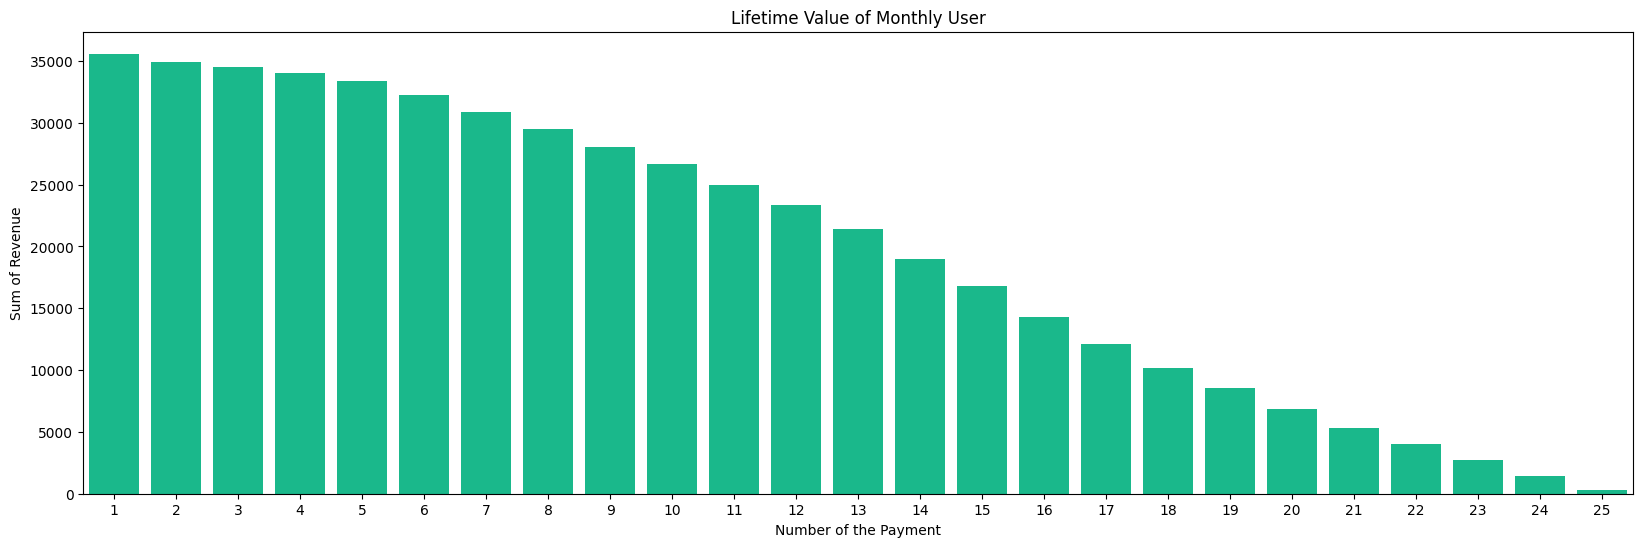

In [8]:
plt.figure(figsize=(20,6))
sns.barplot(data=ltv_chart, x='payment_number', y='revenue', color='#00D296')


plt.title('Lifetime Value of Monthly User')
plt.xlabel('Number of the Payment')
plt.ylabel('Sum of Revenue')

plt.show()

It is a good LTV! On the 12th payment, we have more than half of the revenue yet.
It can be a good plan to reward those monthly customer who renew their subscription for the 12th time, trying to expand the LTV a little bit.

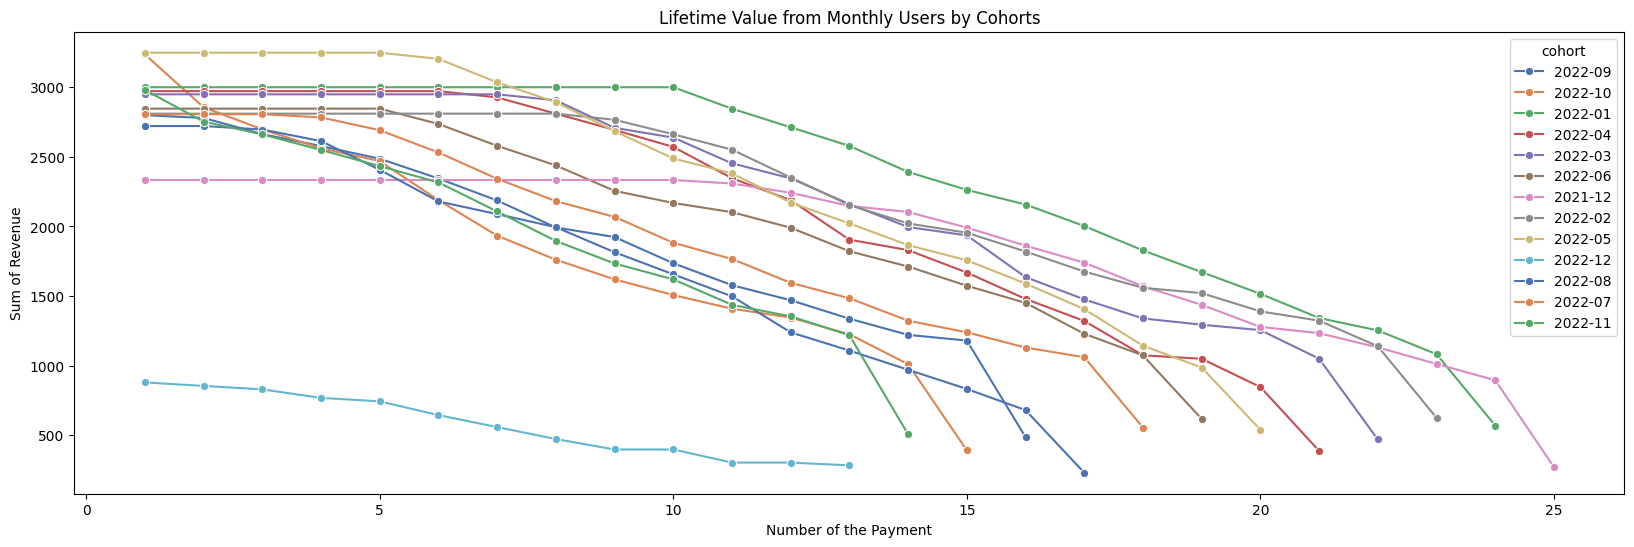

In [9]:
qry = """
    SELECT
        LEFT(subs.subscription_start_at, 7) AS cohort
        , payments.payment_number
        , SUM(payments.payment_value) AS revenue
    FROM
        accrual_basis_payments AS payments
    INNER JOIN
        users_subscriptions AS subs
            ON subs.subscription_id = payments.subscription_id
    WHERE 
        payments.subscription_type = 'Monthly'
    GROUP BY
        LEFT(subs.subscription_start_at, 7)
        , payments.payment_number
"""


cohort_ltv_chart = duckdb.query(qry).df()

# ---------- CHART

plt.figure(figsize=(20,6))
sns.lineplot(data=cohort_ltv_chart, 
             x='payment_number', 
             y='revenue', 
             hue='cohort',
             marker='o',
             palette='deep')

plt.title('Lifetime Value from Monthly Users by Cohorts')
plt.xlabel('Number of the Payment')
plt.ylabel('Sum of Revenue')

plt.show()

The chart above indicates the customers who started their subscription at the end of 2021 and the beginning of 2022, specifically in Dec/21, Jan, and Feb/22, have greater LTV, where no one canceled their subscription until the 10th month, at least.

This can indicate a result of some Black Friday campaigns. 

At the same time, the LTV from customers at the end of 2022 has the smallest LTV.
Maybe the strategy applied in the previous year doesn't work anymore.

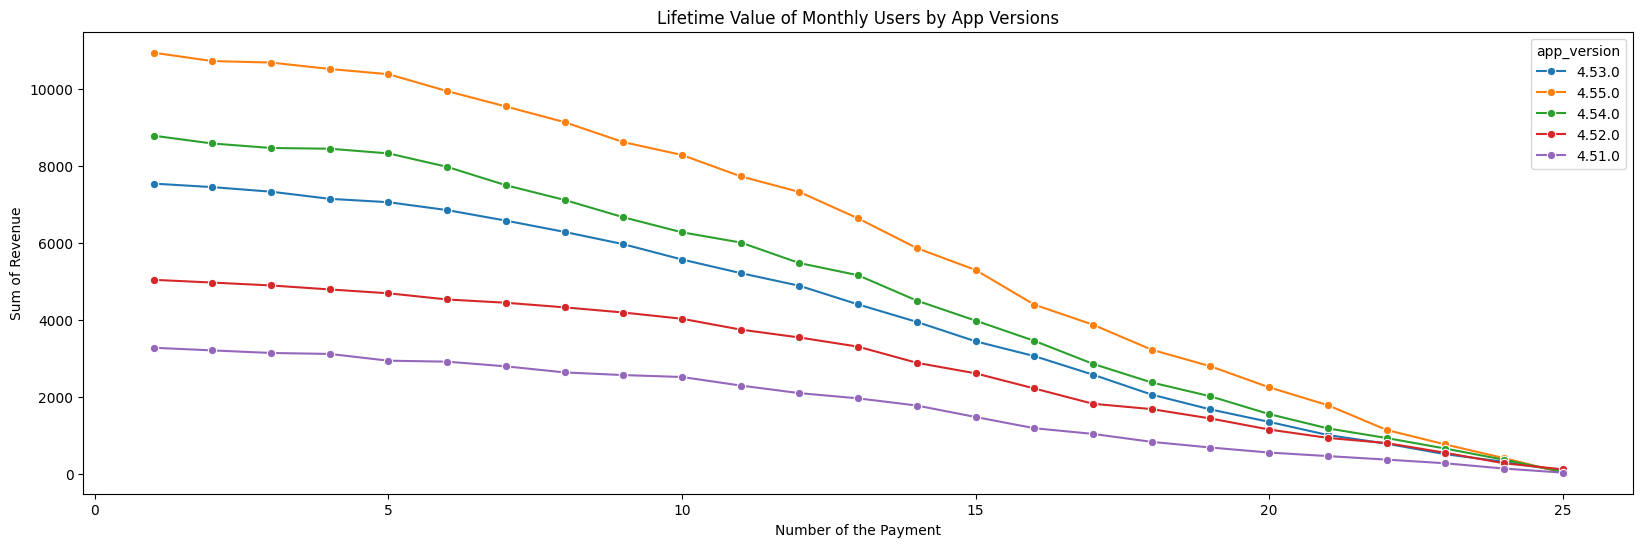

In [10]:
qry = """
    SELECT 
        subs.app_version
        , payments.payment_number
        , SUM(payments.payment_value) AS revenue
    FROM
        accrual_basis_payments AS payments
    INNER JOIN
        users_subscriptions AS subs
            ON subs.subscription_id = payments.subscription_id
    WHERE 
        payments.subscription_type = 'Monthly'
    GROUP BY
        subs.app_version
        , payments.payment_number
"""


app_version_ltv_chart = duckdb.query(qry).df()



# ------------ CHART

plt.figure(figsize=(20,6))
sns.lineplot(data=app_version_ltv_chart, 
             x='payment_number', 
             y='revenue', 
             hue='app_version',
             marker='o',
             color='#00D296')

plt.title('Lifetime Value of Monthly Users by App Versions')
plt.xlabel('Number of the Payment')
plt.ylabel('Sum of Revenue')

plt.show()

There is no big difference in LTV through the app versions.

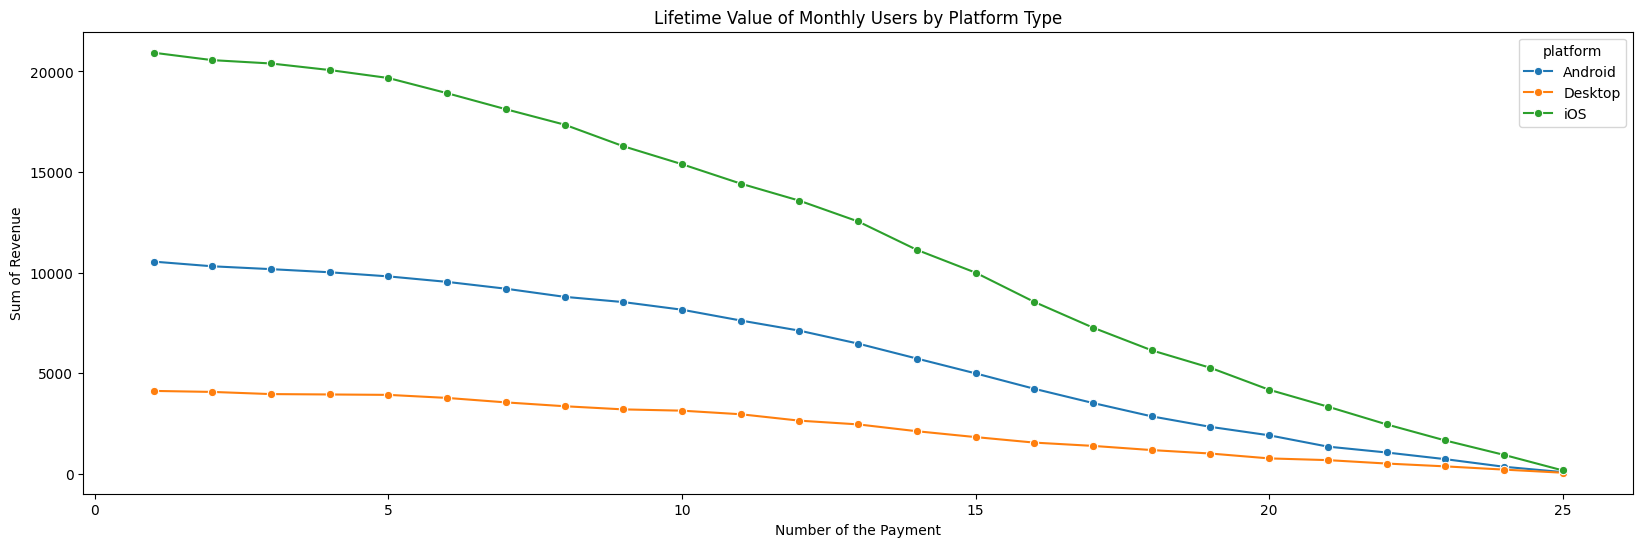

In [11]:
qry = """
    SELECT 
        subs.platform
        , payments.payment_number
        , SUM(payments.payment_value) AS revenue
    FROM
        accrual_basis_payments AS payments
    INNER JOIN
        users_subscriptions AS subs
            ON subs.subscription_id = payments.subscription_id
    WHERE 
        payments.subscription_type = 'Monthly'
    GROUP BY
        subs.platform
        , payments.payment_number
"""


platform_ltv_chart = duckdb.query(qry).df()


# ------------ CHART
plt.figure(figsize=(20,6))
sns.lineplot(data=platform_ltv_chart, 
             x='payment_number', 
             y='revenue', 
             hue='platform',
             marker='o',
             color='#00D296')

plt.title('Lifetime Value of Monthly Users by Platform Type')
plt.xlabel('Number of the Payment')
plt.ylabel('Sum of Revenue')

plt.show()

There is no big difference in LTV through platform type either.

<Figure size 2000x600 with 0 Axes>

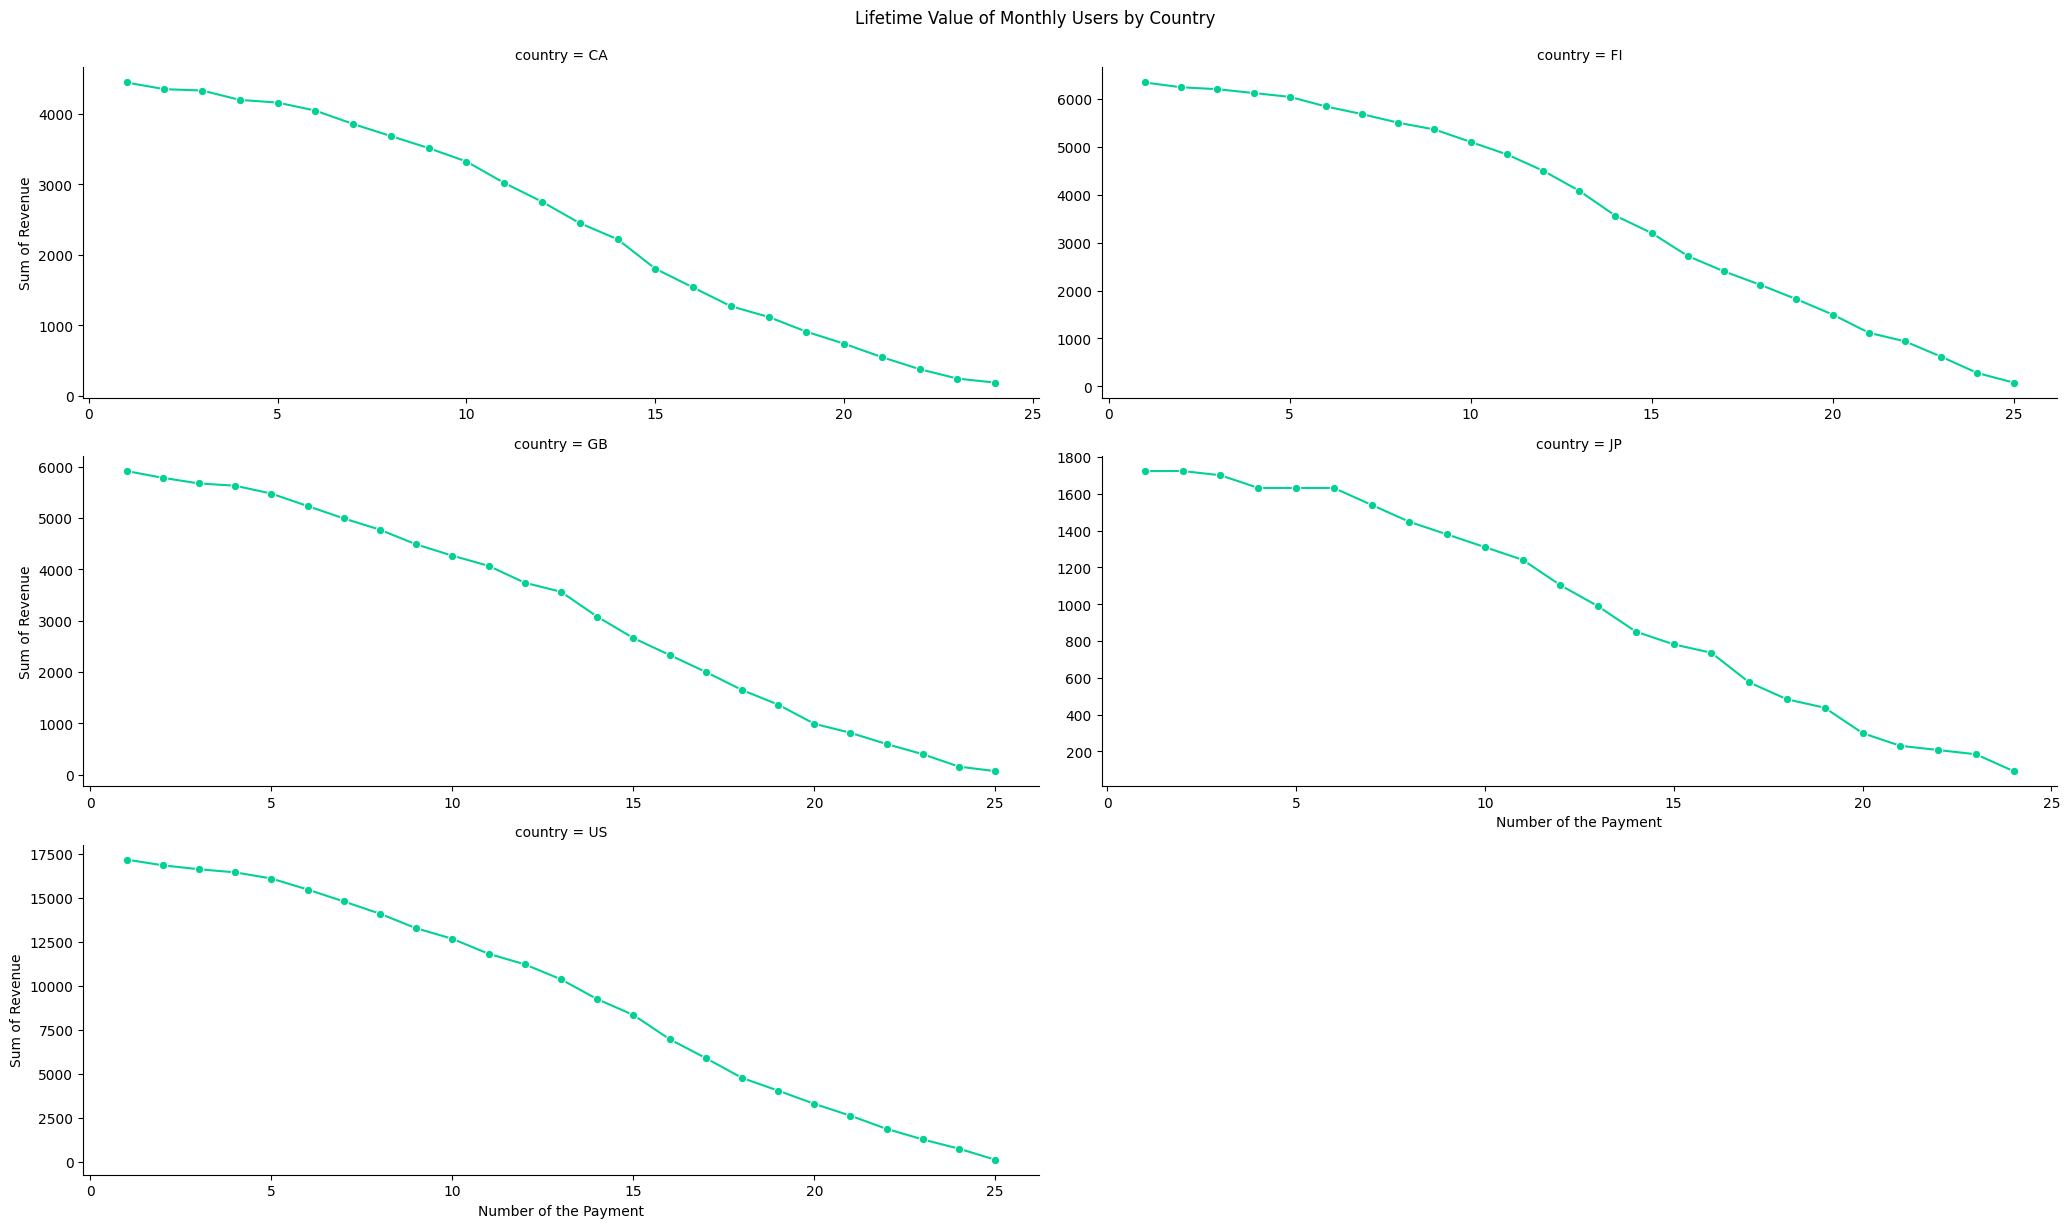

In [12]:
qry = """
    SELECT 
        subs.country
        , payments.payment_number
        , SUM(payments.payment_value) AS revenue
    FROM
        accrual_basis_payments AS payments
    INNER JOIN
        users_subscriptions AS subs
            ON subs.subscription_id = payments.subscription_id
    WHERE 
        payments.subscription_type = 'Monthly'
    GROUP BY
        subs.country
        , payments.payment_number
"""


ltv_chart_by_country = duckdb.query(qry).df()


# ------------ CHART
plt.figure(figsize=(20,6))

g = sns.FacetGrid(ltv_chart_by_country, 
                  col='country', 
                  col_wrap=2, 
                  height=4,
                  aspect=2.6,
                  sharey=False,
                  sharex=False)

g.map(sns.lineplot, 'payment_number', 'revenue', marker='o', color='#00D296')

g.set_axis_labels('Number of the Payment', 'Sum of Revenue')
g.fig.suptitle('Lifetime Value of Monthly Users by Country', y=1.02)

plt.show()

The LTV curve in Finland is a little bit more smothiest than the other countries.

The LTV curve in GB is almost straight. It can be good to equalize the subscription prices in GB, as its price is the third most expensive, behind only of US and JP, and its currency is a more valued than EUR, that is, the impact over the LTV can be higher than on US or CA, for example.

<Figure size 2000x600 with 0 Axes>

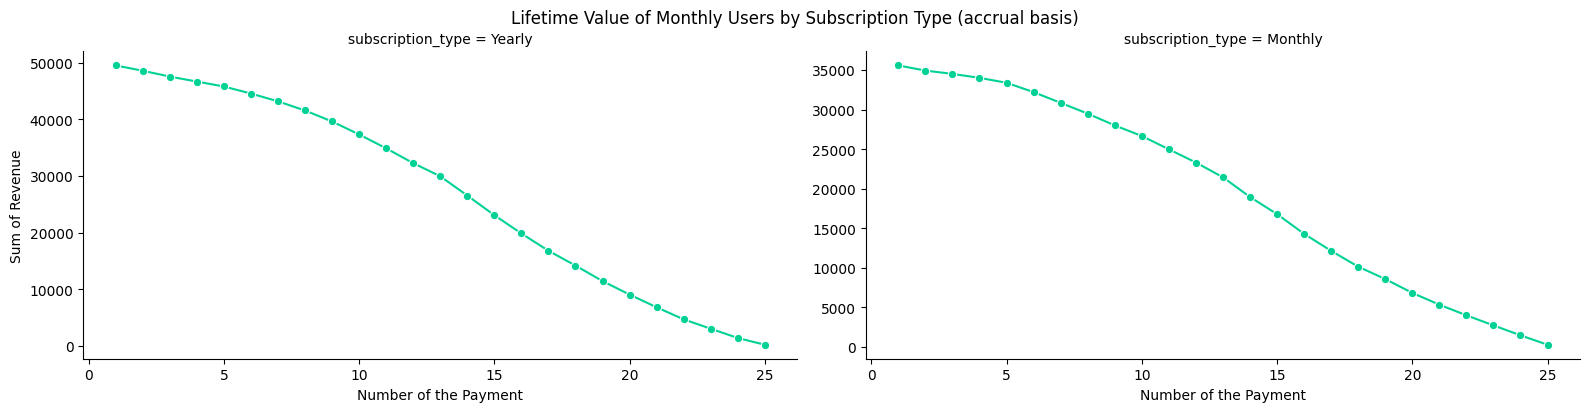

In [13]:
qry = """
    SELECT 
        subs.subscription_type
        , payments.payment_number
        , SUM(payments.payment_value) AS revenue
    FROM
        accrual_basis_payments AS payments
    INNER JOIN
        users_subscriptions AS subs
            ON subs.subscription_id = payments.subscription_id
    GROUP BY
        subs.subscription_type
        , payments.payment_number
"""


ltv_by_subscription_type = duckdb.query(qry).df()


# ------------ CHART
plt.figure(figsize=(20,6))

g = sns.FacetGrid(ltv_by_subscription_type, 
                  col='subscription_type', 
                  col_wrap=2, 
                  height=4,
                  aspect=2,
                  sharey=False,
                  sharex=False)

g.map(sns.lineplot, 'payment_number', 'revenue', marker='o', color='#00D296')

g.set_axis_labels('Number of the Payment', 'Sum of Revenue')
g.fig.suptitle('Lifetime Value of Monthly Users by Subscription Type (accrual basis)', y=1.02)

plt.show()

There is no big difference in LTV curve between subscription types, either it is Monthly or Yearly.

Of course, if we compare this number using cash flow data, it will be different. In this case is better to put these numbers side-by-side looking at the accrual basis payment data.

<Figure size 2000x600 with 0 Axes>

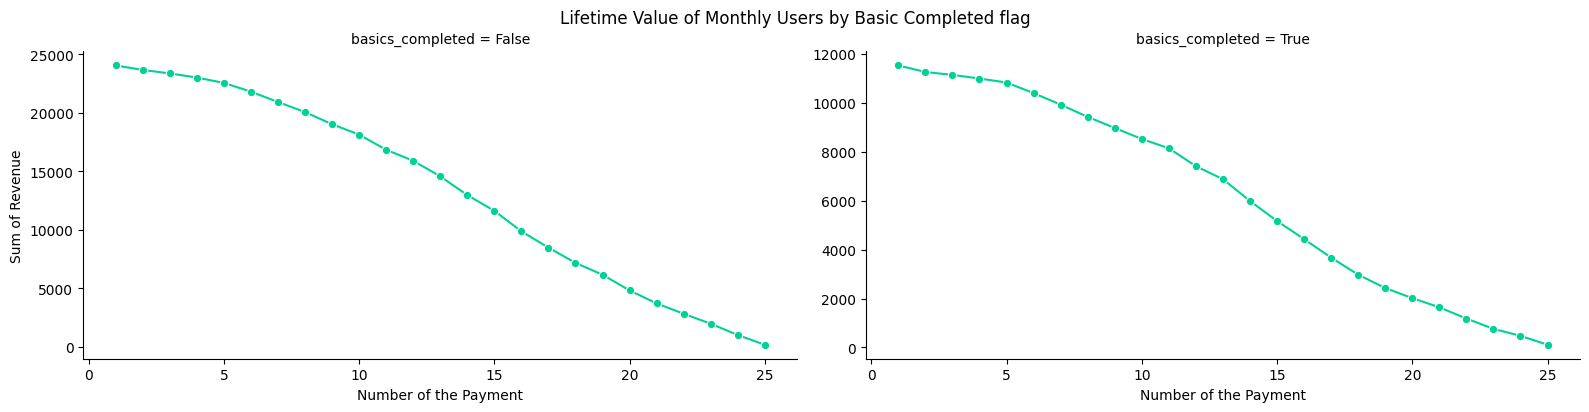

In [18]:
qry = """
    SELECT 
        subs.basics_completed
        , payments.payment_number
        , SUM(payments.payment_value) AS revenue
    FROM
        accrual_basis_payments AS payments
    INNER JOIN
        users_subscriptions AS subs
            ON subs.subscription_id = payments.subscription_id
    WHERE
        subs.subscription_type = 'Monthly'
    GROUP BY
        subs.basics_completed
        , payments.payment_number
"""


ltv_by_basics_completed = duckdb.query(qry).df()


# ------------ CHART
plt.figure(figsize=(20,6))

g = sns.FacetGrid(ltv_by_basics_completed, 
                  col='basics_completed', 
                  col_wrap=2, 
                  height=4,
                  aspect=2,
                  sharey=False,
                  sharex=False)

g.map(sns.lineplot, 'payment_number', 'revenue', marker='o', color='#00D296')

g.set_axis_labels('Number of the Payment', 'Sum of Revenue')
g.fig.suptitle('Lifetime Value of Monthly Users by Basic Completed flag', y=1.02)

plt.show()

# Final Answer:
The average LTV for Monthly users is €310.4, and monthly users renew their subscriptions 12 times, on average.

As we explored the LTV data looking at it from different angles, can be a nice strategy to equalize the subscription price in GB, aiming to expand the LTV a little bit.

Using the data we retrieved, the average ticket on GB is €21.99 (the third more expensive). So, renewing their subscriptions 12 times we get €263.88 as average LTV.
If we decrease the price by just 1 euro, the average ticket would be €20.99. Doing this, if the customers renew their subscription one more time, the LTV would rise to €272.87, meaning +€2,418.31 of revenue without any new subscription.
As the pound is a more valued currency than the euro, making this adjustment in GB can be more effective than in other countries like JP or even the US, maybe resulting in new subscriptions and increasing the revenue even more.